In [22]:
LOGS_FOLDER = '/home/jeyseb/MP/CooperativeGPT/logs/'
simulation_folder1 = LOGS_FOLDER + '/PRUEBA_1_COINS/2024-09-09--14-58-04_coins_1000_scenario0'
prueba = LOGS_FOLDER + 'PRUEBA_1_COINS'

In [23]:
import os
import numpy as np
import pandas as pd


In [24]:
# Read a txt file called scene_track.txt, given a sim folder name. Each line contines a dictionary in txt format.
# Create a dictionary of dictionaries, where the key is the step (each dictionary in each line contains a 'step') and the value is the dictionary of the scene.

agents_ids = {'Juan': 0, 'Bot': 1}

def read_scene_track(sim_folder):
    scene_track = {}
    with open(sim_folder + '/scene_track.txt', 'r') as file:
        for line in file:
            scene = eval(line)
            scene_track[scene['step']] = scene
    return scene_track


def create_coins_indicators(scene_track):
    base_coins = {'yellow_coins': 0, 'red_coins': 0}
    coins_indicators = {'collected_coins': {agent_name: base_coins.copy() for agent_name in agents_ids.keys()}}
    
    initial_step = list(scene_track.keys())[0]
    accum_coins_per_step = {initial_step: {agent_name: base_coins.copy() for agent_name in agents_ids.keys()}}
    
    previous_map = None
    current_map = None
    prev_step = None
    for step in scene_track.keys():
        if not previous_map:
            previous_map = scene_track[step]['current_map'].split('\n')
            prev_step = initial_step
            continue
        
        current_map = scene_track[step]['current_map'].split('\n')
        for agent_name, agent_id in agents_ids.items():
            agent_symbol = str(agent_id)
            for i in range(len(current_map)):
                for j in range(len(current_map[i])):
                    if current_map[i][j] == agent_symbol:
                        if previous_map[i][j] == 'y':
                            coins_indicators['collected_coins'][agent_name]['yellow_coins'] += 1
                            accum_coins_per_step[step][agent_name]['yellow_coins'] = accum_coins_per_step[prev_step][agent_name]['yellow_coins'] + 1
                        elif previous_map[i][j] == 'r':
                            coins_indicators['collected_coins'][agent_name]['red_coins'] += 1
                            accum_coins_per_step[step][agent_name]['red_coins'] = accum_coins_per_step[prev_step][agent_name]['red_coins'] + 1
                    
                    accum_coins_per_step[step] = accum_coins_per_step.get(step, {})
                    prev_agent_dict = accum_coins_per_step[prev_step][agent_name]
                    accum_coins_per_step[step][agent_name] = accum_coins_per_step.get(step, {}).get(agent_name, prev_agent_dict.copy())
                            
        prev_step, previous_map = step, current_map
        
    return coins_indicators, accum_coins_per_step

# Organize the dataframe so each row represents a step in the game
def organize_dataframe(data):
    organized_data = []
    for game, players in data.items():
        step_data = {'Game': game}
        for player, coins in players.items():
            step_data[f'{player}_Yellow_Coins'] = coins['yellow_coins']
            step_data[f'{player}_Red_Coins'] = coins['red_coins']
        organized_data.append(step_data)
    
    # Create DataFrame
    df_organized = pd.DataFrame(organized_data)
    return df_organized        
    

# Calculate rewards for each team per round
def calculate_team_rewards(df, log_path):
    OWN = 3
    OTHER = 1
    PENALTY = -2
    df['Yellow_Team_Reward'] = (
        df['Juan_Yellow_Coins'] * OWN + df['Juan_Red_Coins'] * OTHER +
        df['Bot_Yellow_Coins'] * PENALTY
    )
    
    df['Red_Team_Reward'] = (
        df['Juan_Red_Coins'] * PENALTY +
        df['Bot_Red_Coins'] * OWN + df['Bot_Yellow_Coins'] * OTHER
    )
    # Guardar el DataFrame final
    df.to_csv(log_path + '/df_rewards.csv', index=False)
    
    return df
scene_track1 = read_scene_track(simulation_folder1)
coins_indicators1 = create_coins_indicators(scene_track1)
df_organized = calculate_team_rewards(organize_dataframe(coins_indicators1[1]), simulation_folder1)
df_organized

,Game,Juan_Yellow_Coins,Juan_Red_Coins,Bot_Yellow_Coins,Bot_Red_Coins,Yellow_Team_Reward,Red_Team_Reward
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...
997,998,49,7,1,37,152,98
998,999,49,7,1,37,152,98
999,1000,49,7,1,37,152,98
1000,1001,49,7,1,37,152,98


In [25]:
import matplotlib.pyplot as plt

def plot_rewards(df, log_folder, show=False):
    # Calculate cumulative rewards over time
    df['Cumulative_Yellow_Team_Reward'] = df['Yellow_Team_Reward']
    df['Cumulative_Red_Team_Reward'] = df['Red_Team_Reward']

    # Plot cumulative rewards over time
    plt.figure(figsize=(10, 6))
    plt.plot(df['Game'], df['Cumulative_Yellow_Team_Reward'], label='Yellow Team Cumulative Reward', color='gold')
    plt.plot(df['Game'], df['Cumulative_Red_Team_Reward'], label='Red Team Cumulative Reward', color='red')
    plt.xlabel('Game')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(log_folder + '/cumulative_rewards.png')
    if show:
        plt.show()
    else:
        plt.close()
        
#plot_rewards(df_organized, simulation_folder1, show=True)

In [26]:
def plot_coins_collected(df, log_folder, show=False):
    # Agregar datos de recolección de monedas de Juan y Bot
    player_coin_data = df[['Juan_Yellow_Coins', 'Juan_Red_Coins', 
                           'Bot_Yellow_Coins', 'Bot_Red_Coins']].iloc[-1].reset_index()

    player_coin_data.columns = ['Player_Coin', 'Total_Coins']

    # Separar jugador y tipo de moneda
    player_coin_data['Player'] = player_coin_data['Player_Coin'].apply(lambda x: x.split('_')[0])
    player_coin_data['Coin_Color'] = player_coin_data['Player_Coin'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[2])

    plt.figure(figsize=(12, 6))
    # Crear tabla pivot para una mejor visualización
    pivot_data = player_coin_data.pivot(index='Player', columns='Coin_Color', values='Total_Coins').fillna(0)

    # Graficar el gráfico de barras
    pivot_data.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'gold',  'lightgoldenrodyellow', 'lightcoral'])
    
    plt.xlabel('Player')
    plt.ylabel('Total Coins Collected')
    plt.title('Total Coins Collected by Each Player')
    plt.legend(title='Coin Color')
    plt.grid(axis='y')
    plt.savefig(log_folder + '/coins_collected.png')
    if show:
        plt.show()
    else:
        plt.close()
    

#plot_coins_collected(df_organized, simulation_folder1, show=True)

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_distribution_rewards_penalties(df, log_folder, show=False):
    """
    Gráfico de barras apiladas que muestra la distribución de recompensas y penalizaciones
    para cada equipo por ronda.
    """
    # Calcular penalizaciones para cada ronda
    df['Yellow_Team_Penalty'] = df['Bot_Yellow_Coins'] * 2
    df['Red_Team_Penalty'] = df['Juan_Red_Coins'] * 2

    # Preparar el cálculo total de puntos para la visualización
    df['Yellow_Team_Total'] = df['Yellow_Team_Reward'] + df['Red_Team_Penalty']
    df['Red_Team_Total'] = df['Red_Team_Reward'] + df['Yellow_Team_Penalty']

    # Crear subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Gráfico para el equipo rojo
    ax1.bar(df['Game'], df['Red_Team_Total'], label='Red Team Reward', color='red')
    ax1.bar(df['Game'], df['Red_Team_Penalty'], bottom=df['Red_Team_Total'], label='Red Team Penalty', color='lightcoral')
    ax1.set_xlabel('Game')
    ax1.set_ylabel('Reward/Penalty')
    ax1.set_title('Red Team: Distribution of Rewards and Penalties by Round')
    ax1.legend()
    ax1.grid(True)

    # Gráfico para el equipo amarillo
    ax2.bar(df['Game'], df['Yellow_Team_Total'], label='Yellow Team Reward', color='gold')
    ax2.bar(df['Game'], df['Yellow_Team_Penalty'], bottom=df['Yellow_Team_Total'], label='Yellow Team Penalty', color='darkgoldenrod', alpha=0.75)
    ax2.set_xlabel('Game')
    ax2.set_title('Yellow Team: Distribution of Rewards and Penalties by Round')
    ax2.legend()
    ax2.grid(True)

    # Guardar o mostrar gráfico
    plt.savefig(log_folder + '/rewards_penalties_distribution.png')
    if show:
        plt.show()
    else:
        plt.close()

# Example usage, assuming df_rewards is already defined and loaded
df_rewards = pd.read_csv(simulation_folder1 + '/df_rewards.csv')
#plot_distribution_rewards_penalties(df_rewards, simulation_folder1, show=True)


In [28]:
def plot_rewards_comparison(df, log_folder, show=False):
    # Calcular recompensas totales para cada equipo
    total_rewards = df[['Yellow_Team_Reward', 'Red_Team_Reward']].iloc[-1].reset_index()
    total_rewards.columns = ['Team', 'Total_Reward']

    # Graficar el gráfico de barras para comparar las recompensas totales
    plt.figure(figsize=(10, 6))
    plt.bar(total_rewards['Team'], total_rewards['Total_Reward'], color=['gold', 'red'])
    plt.xlabel('Team')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards Earned by Each Team')
    plt.grid(axis='y')
    plt.savefig(log_folder + '/rewards_comparison.png')
    if show:
        plt.show()
    else:
        plt.close()
    
#plot_rewards_comparison(df_organized, simulation_folder1)

In [29]:
from PIL import Image
import os

def create_dashboard_image(sim_folder, show=False):
    # Function calls for necessary operations
    scene_track = read_scene_track(sim_folder)
    coins_indicators = create_coins_indicators(scene_track)
    df_organized = calculate_team_rewards(organize_dataframe(coins_indicators[1]), sim_folder)
    plot_rewards(df_organized, sim_folder)
    plot_coins_collected(df_organized, sim_folder)
    plot_distribution_rewards_penalties(df_organized, sim_folder)
    plot_rewards_comparison(df_organized, sim_folder)
    
    # Image paths
    image_paths = [
        os.path.join(sim_folder, 'cumulative_rewards.png'),
        os.path.join(sim_folder, 'coins_collected.png'),
        os.path.join(sim_folder, 'rewards_comparison.png'),
        os.path.join(sim_folder, 'rewards_penalties_distribution.png'),
    ]
    
    # Open images
    images = [Image.open(path) for path in image_paths]
    
    # Determine the maximum width and height of the individual images
    max_width = max(im.width for im in images)
    max_height = max(im.height for im in images)
    
    # Calculate total width and height for the 2x2 grid
    total_width = max_width * 2
    total_height = max_height * 2
    
    # Create a new blank image with the calculated total width and height
    new_im = Image.new('RGB', (total_width, total_height))
    
    # Paste images into the new image at the correct positions
    positions = [(0, 0), (max_width, 0), (0, max_height), (max_width, max_height)]
    for pos, im in zip(positions, images):
        new_im.paste(im, pos)
    
    # Save the new image
    new_im.save(os.path.join(sim_folder, 'dashboard.png'))
    
    # Optionally show the new image
    if show:
        new_im.show()
        
# Example call to the function
#create_dashboard_image(simulation_folder1, show=True)

In [30]:
from PIL import Image
import os

def create_dashboard_image(sim_folder, show=False):
    # Function calls for necessary operations
    scene_track = read_scene_track(sim_folder)
    coins_indicators = create_coins_indicators(scene_track)
    df_organized = calculate_team_rewards(organize_dataframe(coins_indicators[1]), sim_folder)
    plot_rewards(df_organized, sim_folder)
    plot_coins_collected(df_organized, sim_folder)
    plot_distribution_rewards_penalties(df_organized, sim_folder)
    plot_rewards_comparison(df_organized, sim_folder)
    
    # Image paths
    image_paths = [
        os.path.join(sim_folder, 'rewards_comparison.png'),
        os.path.join(sim_folder, 'coins_collected.png'),
        os.path.join(sim_folder, 'cumulative_rewards.png'),
        os.path.join(sim_folder, 'rewards_penalties_distribution.png'),
    ]
    
    # Open images
    images = [Image.open(path) for path in image_paths]

    # Use dimensions of the first two images for the first row (assuming they are the same)
    max_width_row1 = images[0].width + images[1].width
    max_height_row1 = max(images[0].height, images[1].height)

    # Use dimensions of the last two images for the second row (assuming they are the same)
    max_width_row2 = images[2].width + images[3].width
    max_height_row2 = max(images[2].height, images[3].height)

    # Calculate total width and height
    total_width = max(max_width_row1, max_width_row2)
    total_height = max_height_row1 + max_height_row2
    
    # Create a new blank image
    new_im = Image.new('RGB', (total_width, total_height))

    # Define positions manually, aligning everything to the left
    positions = [
        (0, 0),  # Top left
        (images[0].width, 0),  # Top right
        (0, max_height_row1),  # Bottom left
        (images[2].width, max_height_row1)  # Bottom right (adjust x based on the width of the third image)
    ]

    # Paste images into the new image at the correct positions
    for pos, im in zip(positions, images):
        new_im.paste(im, pos)
    
    # Save the new image
    new_im.save(os.path.join(sim_folder, 'dashboard.png'))
    
    # Optionally show the new image
    if show:
        new_im.show()

# Example call to the function
#create_dashboard_image(simulation_folder1, show=True)


In [31]:
simulation_folder1 = LOGS_FOLDER + '/PRUEBA_1_COINS/2024-09-09--14-58-04_coins_1000_scenario0'
create_dashboard_image(simulation_folder1, show=True)

<Figure size 1200x600 with 0 Axes>

In [32]:
simulation_folder2 = LOGS_FOLDER + '2024-06-14--02-53-15'
create_dashboard_image(simulation_folder2, show=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jeyseb/MP/CooperativeGPT/logs/2024-06-14--02-53-15/scene_track.txt'

Error: no "view" mailcap rules found for type "image/png"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.
Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "/tmp/tmpk9pa9lxd.PNG"
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


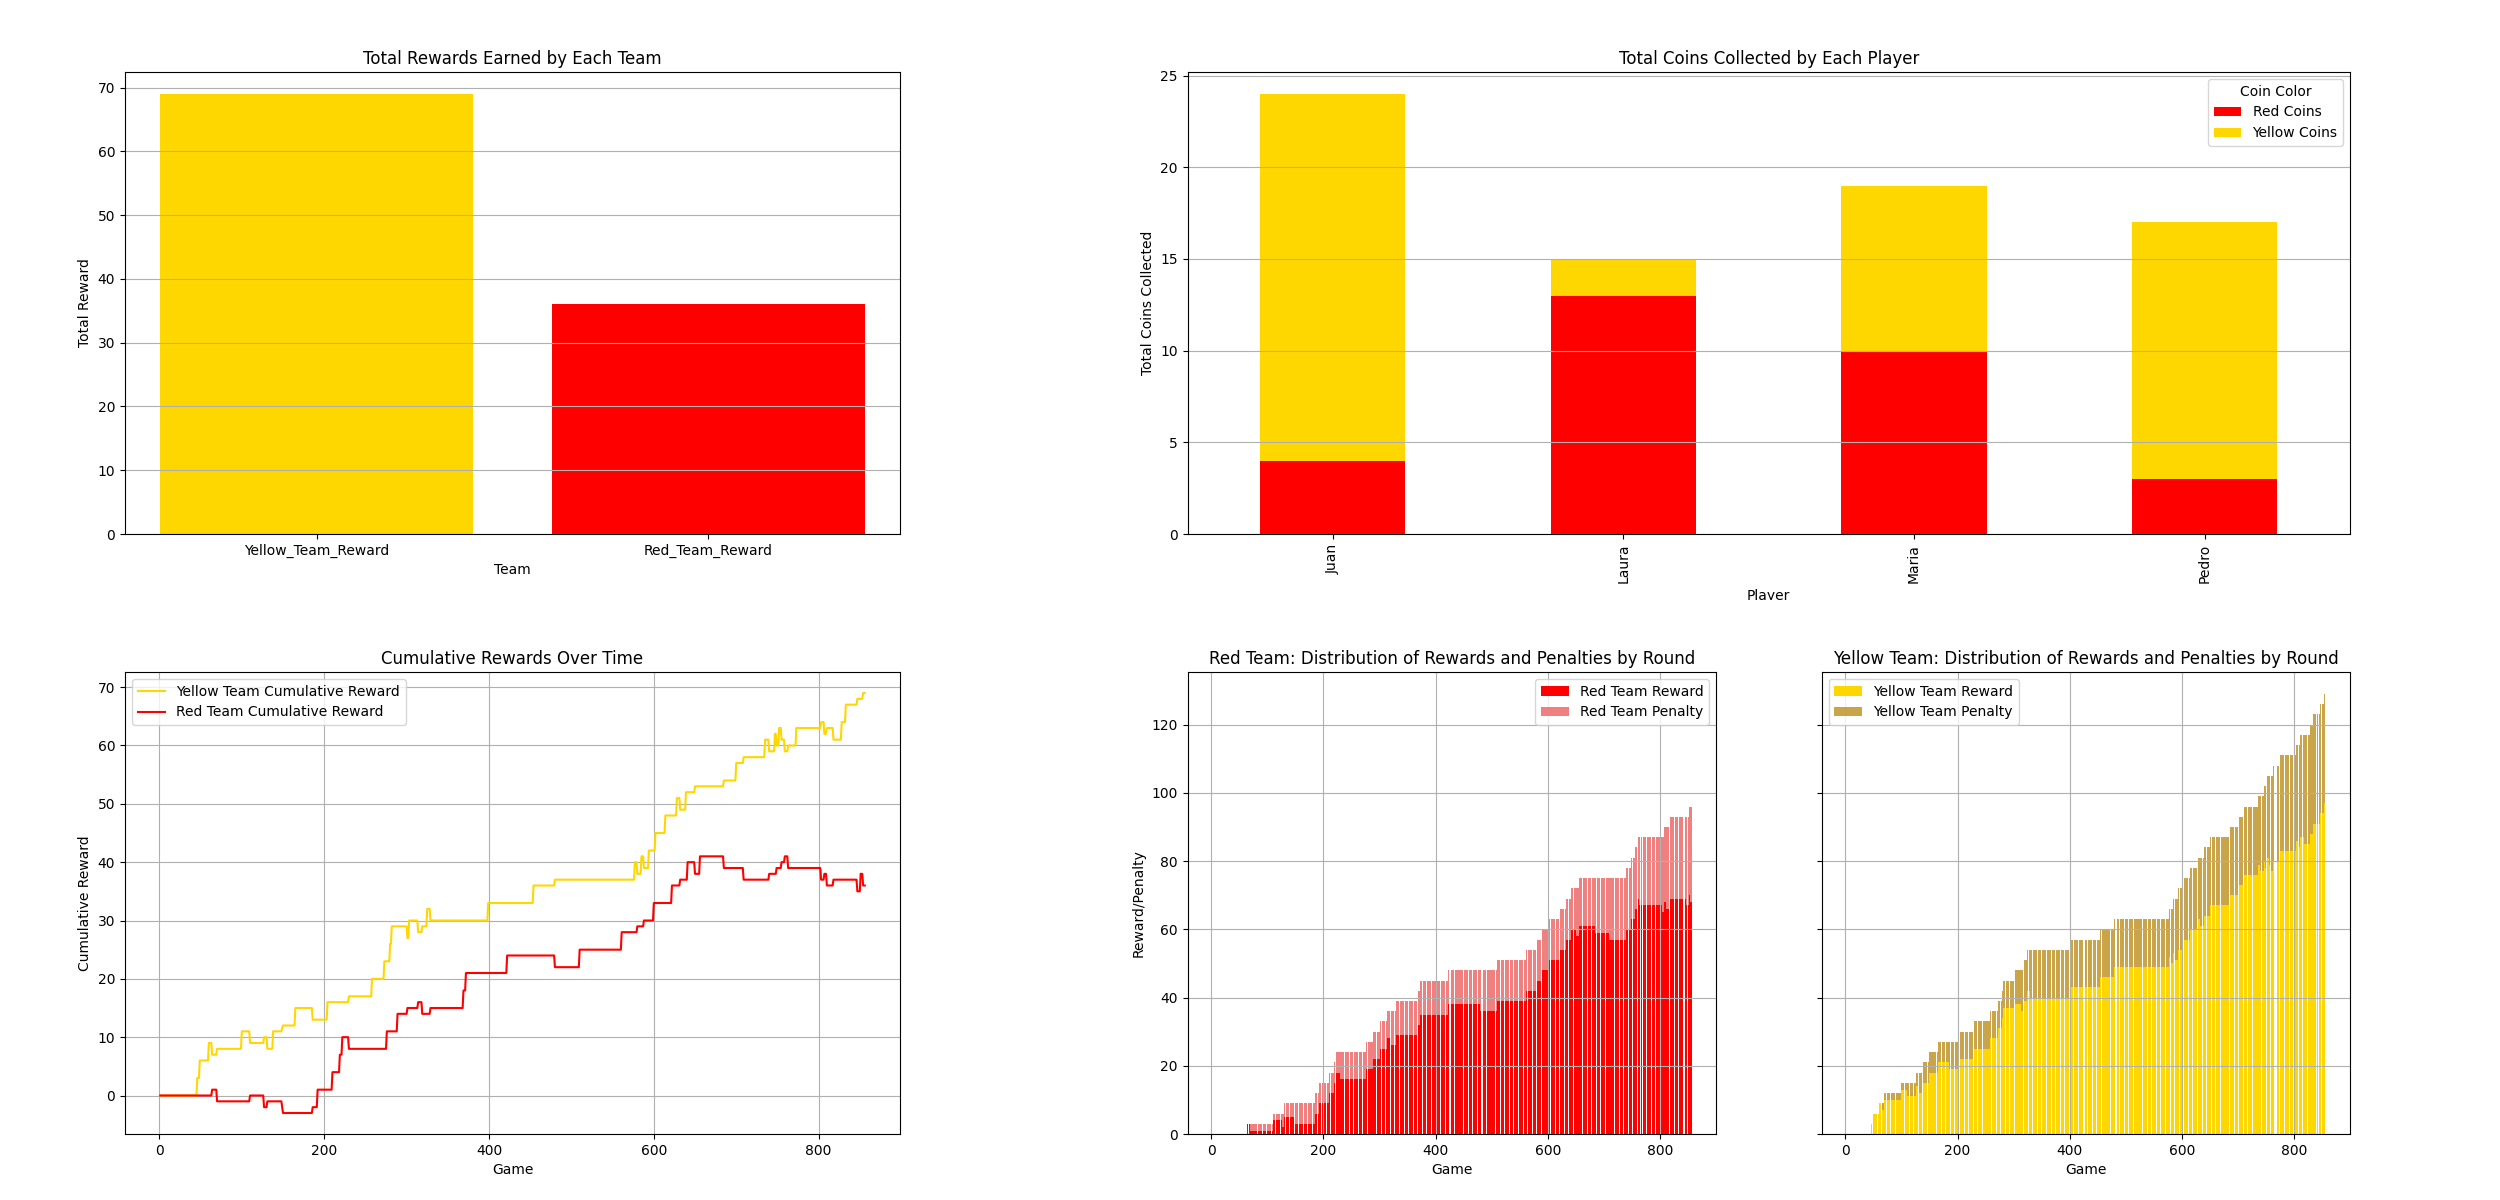

<Figure size 1200x600 with 0 Axes>

In [12]:
simulation_folder3 = LOGS_FOLDER + '2024-06-14--02-53-20'
create_dashboard_image(simulation_folder3, show=True)